In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.io import ImageReadMode
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode as IM
import os
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Loading Model to MPS Backend
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("MPS device ASSIGNED!.")
else:
    mps_device = torch.device('cpu')
    print("MPS device not found.")

MPS device ASSIGNED!.


## DeepLab V3

Inverted convolution
Squeeze adn excitation
Depthwise-seperable Conv


In [3]:
class SqueezeAndExcitation(nn.Module):
    def __init__(self, c, ratio=8):
        super().__init__()
        self.ratio = ratio
        self.L1 = nn.Linear(c, c // self.ratio)
        self.L2 = nn.Linear(c // self.ratio, c)

    def forward(self, inputs):
        b = inputs.size(0)
        c = inputs.size(1)
        x = F.adaptive_avg_pool2d(inputs, 1)  # (batch_size, channels)
        # device=self.device
        x = self.L1(x.view(b, c))
        x = F.relu(x)
        # device=self.device
        x = self.L2(x)
        x = torch.sigmoid(x)
        x = x.view(b, c, 1, 1)
        x = F.relu(inputs * x)
        return x

In [4]:
class BlockResNet(nn.Module):
    def __init__(self, input_c, output_c, device, kernel_size=3, K=1, stride=1, dilation=1, use_bias=True, depth=True):
        super(BlockResNet, self).__init__()
        self.k_s = kernel_size
        self.dia = dilation
        self.s = stride
        self.depth = depth
        self.device = device
        self.out = output_c
        # For stride = 1
        

        # For Stride = 2
        if stride == 2:
            self.conv_2 = nn.Conv2d(in_channels=input_c, out_channels=input_c*2, kernel_size=1,
                                    stride=1, padding='same', groups=1)
            if (dilation != 1):
                self.depthwise_2 = nn.Conv2d(in_channels=input_c*2, out_channels=K*input_c*2,
                                            kernel_size=kernel_size, padding=1, stride=1,
                                            dilation=dilation, groups=input_c*2)
            else:
                self.depthwise_2 = nn.Conv2d(in_channels=input_c*2, out_channels=K*input_c*2,  # padding =1 will lead to half the size
                                            kernel_size=kernel_size, padding=1, stride=stride,
                                            dilation=1, groups=input_c*2)
            self.pointwise_concat = nn.Conv2d(in_channels=input_c, out_channels=output_c,
                                            kernel_size=1, padding='valid', stride=2,
                                            groups=1)
            self.pointwise_comp_2 = nn.Conv2d(in_channels=K*input_c*2, out_channels=output_c,
                                        kernel_size=1, padding='same', stride=1,
                                        groups=1)
            self.batchn21 = nn.BatchNorm2d(input_c*2, momentum=0.001)
            self.batchn22 = nn.BatchNorm2d(input_c*2, momentum=0.001)
            self.batchn23 = nn.BatchNorm2d(output_c, momentum=0.001)
            self.batchn24 = nn.BatchNorm2d(output_c, momentum=0.001)
            self.SqueezeAndExcitation = SqueezeAndExcitation(output_c)

        else:  
            self.pointwise_exp = nn.Conv2d(in_channels=input_c, out_channels=input_c*2,
                                       kernel_size=1, padding='same', stride=1,
                                       dilation=dilation, groups=1)
            self.depthwise = nn.Conv2d(in_channels=input_c*2, out_channels=K*input_c*2,
                                   kernel_size=kernel_size, padding='same', stride=1,
                                   dilation=dilation, groups=input_c*2)
            self.pointwise_comp = nn.Conv2d(in_channels=K*input_c*2, out_channels=output_c,
                                        kernel_size=1, padding='same', stride=1,
                                        groups=1)
            self.batchn11 = nn.BatchNorm2d(input_c*2, momentum=0.001)
            self.batchn12 = nn.BatchNorm2d(input_c*2, momentum=0.001)
            self.batchn13 = nn.BatchNorm2d(output_c, momentum=0.001)
            
            self.SqueezeAndExcitation = SqueezeAndExcitation(output_c)
    
    def forward(self, input):

        if self.depth == True:

            if self.s == 1:
                # ResNet Block (Depth-seperable conv)
                g1 = F.relu(self.batchn11(self.pointwise_exp(input)))
                g1 = F.relu(self.batchn12(self.depthwise(g1)))
                g1 = F.relu(self.batchn13(self.pointwise_comp(g1)))
                g1 = self.SqueezeAndExcitation(g1)
                # Concate
                g1 = F.relu(g1 + input)
                
                return g1

            elif self.s == 2:
                # padding = (input.size(2)+self.k_s-2)//2
                # g1 = F.pad(g1, (padding, padding+1, padding, padding+1))
                # ResNet Block (Depth-seperable conv)
                g1 = F.relu(self.batchn21(self.conv_2(input)))
                g1 = F.relu(self.batchn22(self.depthwise_2(g1)))
                g1 = F.relu(self.batchn23(self.pointwise_comp_2(g1)))
                # Concate
                # convert to required channels
                input = F.relu(self.batchn23(self.pointwise_concat(input)))
                g1 = self.SqueezeAndExcitation(g1)
                g1 = F.relu(g1 + input)
                return g1

            else:
                print("Only Stride 1 or 2 allowed")
                return 1

        else:
            print("For Now only Depthwise allowed")
            return 1

In [5]:
class ASPP(nn.Module):
    def __init__(self, input_c=256, multigrid=(1, 2, 3), ratio=6, K=1):
        super(ASPP, self).__init__()

        self.multigrid = multigrid
        self.b_1 = nn.Conv2d(in_channels=input_c, out_channels=K*input_c,
                             kernel_size=(3, 3), padding='same', stride=1,
                             dilation=self.multigrid[0]*ratio, groups=input_c)
        self.b_2 = nn.Conv2d(in_channels=input_c, out_channels=K*input_c,
                             kernel_size=(3, 3), padding='same', stride=1,
                             dilation=self.multigrid[1]*ratio, groups=input_c)
        self.b_3 = nn.Conv2d(in_channels=input_c, out_channels=K*input_c,
                             kernel_size=(3, 3), padding='same', stride=1,
                             dilation=self.multigrid[2]*ratio, groups=input_c)
        self.b_1x1 = nn.Conv2d(in_channels=input_c, out_channels=K*input_c,
                               kernel_size=(1, 1), padding='same', stride=1,
                               dilation=self.multigrid[0]*ratio, groups=input_c)

        self.pooling_conv = nn.Conv2d(in_channels=input_c, out_channels=input_c,
                                      kernel_size=(1, 1), padding='same', stride=1,
                                      groups=1)
        self.out_pool = nn.Upsample(size = (32,32), mode='bilinear')
        self.final_conv = nn.Conv2d(in_channels=input_c*5, out_channels=input_c,
                                    kernel_size=(1, 1), padding='same', stride=1,
                                    groups=1)
        self.batchn1 = nn.BatchNorm2d(input_c)
        self.batchn2 = nn.BatchNorm2d(input_c)
        self.batchn3 = nn.BatchNorm2d(input_c)
        self.batchn4 = nn.BatchNorm2d(input_c)
        self.batchn5 = nn.BatchNorm2d(input_c)
        self.batchn6 = nn.BatchNorm2d(input_c)
        self.batchn7 = nn.BatchNorm2d(input_c)
        self.SqueezeAndExcitation = SqueezeAndExcitation(input_c*5)
    def forward(self, inputs):
        b_1 = F.relu(self.batchn1(self.b_1(inputs)))
        b_2 = F.relu(self.batchn2(self.b_2(inputs)))
        b_3 = F.relu(self.batchn3(self.b_3(inputs)))
        b_1x1 = F.relu(self.batchn4(self.b_1x1(inputs)))
        
        k = b_3.size(2)
        n = b_3.size(3)
        out_pool = F.adaptive_avg_pool2d(inputs, 1)
        out_pool = out_pool.reshape(inputs.size(0), inputs.size(1), 1, 1)
        out_pool = F.relu(self.batchn6(self.pooling_conv(out_pool)))   
        # out_pool = self.out_pool(out_pool)

        x = torch.cat((b_1, b_2, b_3, b_1x1, out_pool.repeat(1,1,k,n)), dim=1)
        x = self.SqueezeAndExcitation(x)
        x = F.relu(self.batchn7(self.final_conv(x)))
    
        return x

In [6]:
class DeepLab(nn.Module):
    def __init__(self, input_c, num_classes, device, num_block=3):
        super(DeepLab, self).__init__()
        self.ks = 64
        self.final_input = (self.ks*(num_block+1))+(self.ks)
        self.c_1 = nn.Conv2d(in_channels=input_c, out_channels=self.ks,
                             kernel_size=(7, 7), padding=3, stride=2)
        self.mp_1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.block_1 = BlockResNet(self.ks, self.ks, device=device)
        self.block_1_2 = BlockResNet(
            self.ks, self.ks*2, stride=2, device=device)
        self.block_2 = BlockResNet(self.ks*2, self.ks*2, device=device)
        self.block_2_2 = BlockResNet(
            self.ks*2, self.ks*4, stride=2, device=device)
        self.block_3 = BlockResNet(
            self.ks*4, self.ks*4, dilation=2, device=device)
        self.assp = ASPP()
        self.upsample = nn.Upsample(scale_factor=4)
        self.conv_3x3 = nn.Conv2d(in_channels=self.final_input, out_channels=num_classes,
                                  stride=1, kernel_size=(3, 3), padding='same')
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        x = self.c_1(inputs)
        x = self.mp_1(x)

        for _ in range(3):   # Block 1
            x = self.block_1(x)
        skip = x
        x = self.block_1_2(x)

        for _ in range(3):   # Block 2
            x = self.block_2(x)
        x = self.block_2_2(x)

        for _ in range(3):  # Block 3
            x = self.block_3(x)
        x = self.assp(x)

        x = self.upsample(x)
        x = torch.cat([skip, x], dim=1)

        x = self.conv_3x3(x)
        x = self.softmax(x)
        x = self.upsample(x)

        return x

## Function Definitions


In [7]:
def save_checkpoint(state, filename,run_name,extension):
    x = os.path.join(filename,run_name+extension)
    if os.path.exists(x):
        torch.save(state, x)
        print("Saving Checkpoint")
        return
    else:
        with open(x, 'w') as fp:
            fp.close()
        # If model is running for first time then Save
        torch.save(state, x)
        print("Saving Checkpoint")
        return

In [8]:
def meanIOU(true, predicted):
    # Calculates mIOU for a mini-batch
    predicted_arr = predicted.clone().detach().cpu().numpy().argmax(1)
    groundt = true.clone().detach().cpu().numpy()
    intersection = np.logical_and(groundt, predicted_arr).sum()
    union = np.logical_or(groundt, predicted_arr).sum()

    iou_score = intersection / union

    return iou_score

In [9]:
# Accuracy check function
def check_accuracy(loader, model):
    if loader.dataset.train:
        print("testing on training data")
    else:
        print("Testing on Testing data")
    correct = 0
    iou = 0
    num_samples = 0
    model.eval()  # We're telling model to shift to eval mode

    with torch.no_grad():   # we dont want the model to calculate the graidents
        # just the outputs are required as model is already trained
        start1 = time.time()
        for x, y in loader:
            x = x.to(mps_device)
            y = y.to(mps_device)
            num_samples += x.size(0)*y.size(1)*y.size(2)
            scores = model(x)
            preds = scores.clone().detach().max(1)[1]
            correct += preds.eq(y).sum().item()
            iou += meanIOU(y,scores)
            

        # end = time.time()
        # print(f"epoch {epochs} time : {start-end}")
        epoch_accuracy = round((correct / (num_samples))*100,2)
        print("val_accuracy : ", epoch_accuracy)
        model.train()
        return round(epoch_accuracy, 2), iou/len(loader)

## Dataset


In [10]:
train_root = 'dataset/images/train/'
train_mask_root = 'dataset/mask/train/'

test_root = 'dataset/images/val/'
test_mask_root = 'dataset/mask/val/'

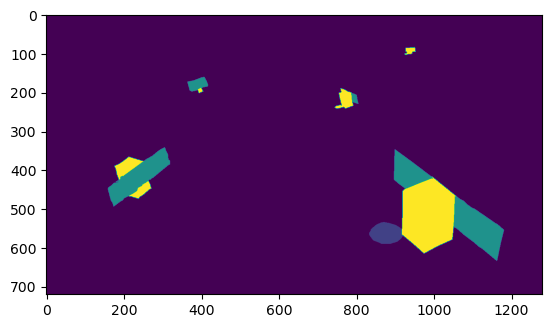

tensor([  0,  29,  76, 149], dtype=torch.uint8)
torch.Size([1, 720, 1280])
<class 'torch.Tensor'>


False

In [11]:
# RANDOM TEST
im1 = os.path.join(train_root, 'img_resize_0.png')
mas1 = os.path.join(train_mask_root, 'img_resize_133.png')

x = torchvision.io.read_image(mas1, mode=ImageReadMode.GRAY)
plt.imshow(x.permute(1, 2, 0))
plt.show()

print(torch.unique(x))
print(x.shape)
print(type(x))
os.path.isfile(train_root)

In [12]:
# To remove _mask at the end of each file to make it cosistent while sorting
for filename in os.listdir(train_mask_root):
    file_path = os.path.join(train_mask_root, filename)

    if os.path.isfile(file_path):
        file_name, file_extension = os.path.splitext(filename)

        # Split the file name into words and remove the last 3 words
        if file_name.endswith('_mask'):
            new_file_name = file_name[:-5] + file_extension
            new_file_path = os.path.join(train_mask_root, new_file_name)
            os.rename(file_path, new_file_path)
            print(f"Renamed: {filename} -> {new_file_name}")

In [13]:
class sat_dataset(Dataset):
    def __init__(self, root, mask_root, inp_shape, transform=None, interpolation=IM.BILINEAR, train=True):
        self.images = os.listdir(root)
        self.masks = os.listdir(mask_root)
        self.train_bool = train
        self.root = root
        self.mask_root = mask_root
        self.transform = transform
        self.inp_shape = inp_shape
        self.interpolation = interpolation
        self.resize = transforms.Resize(size=self.inp_shape, interpolation=self.interpolation,
                                        antialias=True)
        for i in self.images:
            if (i == '.DS_Store'):
                self.images.remove('.DS_Store')
        for i in self.masks:
            if (i == '.DS_Store'):
                self.masks.remove('.DS_Store')
        self.images.sort()
        self.masks.sort()

    def __len__(self):
        return len(self.images)

    def train(self) -> bool:
        return self.train_bool

    def __getitem__(self, index):

        img_path = os.path.join(self.root, self.images[index])
        img = torchvision.io.read_image(img_path, mode=ImageReadMode.RGB)
        # Always use RGB as mode or else it ouputs 4 dim sometimes
        img_path = os.path.join(self.mask_root, self.masks[index])
        mask = torchvision.io.read_image(img_path, mode=ImageReadMode.GRAY)

        # One-Hot encoding mask
        mask = mask.numpy()
        # Define the mapping from original values to new values
        value_mapping = {0: 0, 76: 1, 149: 2, 29: 3}  # 149 -> yellow
        # 76-> green_blue
        # 29 -> blue
        # Apply the mapping to the entire image array
        mask = np.vectorize(value_mapping.get)(mask)
        mask = torch.tensor(mask, dtype=torch.long)
        # print(torch.unique(mask))
        # print(mask.shape)

        img = img/255.0

        # img = img.astype(np.float32)
        # mask = mask.astype(np.float32)

        if (self.transform):
            img = self.transform(img)
            mask = self.transform(mask)

        img = self.resize(img)
        mask = self.resize(mask)
        mask = mask.squeeze(0)

        return img, mask

## Training


In [14]:
classes = 4
learning_rate = 0.001
batch_size = 10
num_epochs = 100
filename = 'model_runs'
run_name = 'DeepLab_new'
extension = '.pth.tar'
inputH = 512
inputW = 512

inp_dim = (inputH, inputW)
inputC = 3
class_weight = torch.tensor([0.29, 1.2, 0.7, 20], device=torch.device('mps'))
mps_device = torch.device('mps')
model1 = DeepLab(input_c=inputC, num_classes=classes, device=mps_device)
model = model1.to(mps_device)
metrics = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

In [15]:
sat_train_data = sat_dataset(root=train_root, mask_root=train_mask_root,
                             inp_shape=inp_dim,
                             #  transform=transforms.ToTensor()
                             )
train_loader = DataLoader(dataset=sat_train_data,
                          shuffle=True, batch_size=batch_size)

sat_test_data = sat_dataset(root=test_root, mask_root=test_mask_root,
                             inp_shape=inp_dim,train=False
                             #  transform=transforms.ToTensor()
                             )
test_loader = DataLoader(dataset=sat_test_data,
                          shuffle=True, batch_size=batch_size)

In [16]:
if (os.path.isfile(os.path.join(run_name+extension))):
    prev_model = torch.load(os.path.join(run_name+extension))
    model.load_state_dict(prev_model['state_dict'])
    max_iou = prev_model['m_iou']
else:
    max_iou = 0

In [17]:
val_acc_l = []
train_acc_l = []
loss_l = []

In [ ]:
for epochs in range(num_epochs):
    # start = time.time()
    num_samples = 0
    iou = 0
    final_loss = 0
    correct = 0
    loop = tqdm(train_loader)

    for batch_idx, (train, targets) in enumerate(loop):
        data = train.to(mps_device)
        targets = targets.to(mps_device)  # now we have loaded the data

        num_samples += data.size(0)  # Clac num_samples to calc average loss
        scores = model(data)
        
        loss = metrics(scores, targets)
        final_loss += loss.item()  # to calculate average loss
        
        # gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # OVerall acc
        preds = scores.clone().detach().max(1)[1]
        correct += preds.eq(targets).sum().item()
    # end = time.time()
    # print(f"epoch {epochs} time : {start-end}")
    final_loss = final_loss/num_samples
    epoch_accuracy = round((correct / (num_samples*inputH*inputW))*100, 3)
    scheduler.step(final_loss)
    val_acc, iou = check_accuracy(test_loader, model)
    
    val_acc_l.append(val_acc)
    train_acc_l.append(epoch_accuracy)
    loss_l.append(final_loss)
    
    print("train_accuracy : ", epoch_accuracy)
    print(f"IoU : ", iou)
    print(f"Loss {epochs} : {final_loss:5f}")

    if (iou > max_iou):
        max_iou = iou
        min_loss = final_loss
        checkpoint = {'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'val_accuracy': val_acc,
                      'train_accuracy': epoch_accuracy,
                      'epoch': epochs,
                      'loss': final_loss,
                      'm_iou':iou}
        save_checkpoint(checkpoint,'',run_name,extension)

## Testing


In [ ]:
# Custom Test data
sat_test_data = sat_dataset(test_root, test_mask_root, train=False,
                            inp_shape=inp_dim)
# transform=transforms.ToTensor())
test_loader = DataLoader(sat_test_data, shuffle=True, batch_size=batch_size)

In [ ]:
def one_item_test(i):

    x, y = sat_test_data.__getitem__(i)
    x = x.unsqueeze(0)  # as there is no batch size
    y = y.unsqueeze(0)  # add an extra dimension to fit the model
    x = x.to(mps_device)
    y = y.to(mps_device)

    scores = model(x)
    _, predictions = scores.max(1)

    # making shape compatible for numpy operation
    predictions = predictions.cpu().numpy()
    y = y.cpu().numpy()
    shape = (1, inputH, inputW)  # shape of output of model
    y = np.resize(y, (shape[1], shape[2], shape[0]))
    predictions = np.resize(predictions, (shape[1], shape[2], shape[0]))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the first image on the left subplot
    # Adjust colormap and limits as needed
    axes[0].imshow(y, cmap='viridis', vmin=0, vmax=3)
    axes[0].set_title("Ground Truth")

    # Plot the second image on the right subplot
    # Adjust colormap and limits as needed
    axes[1].imshow(predictions, cmap='viridis', vmin=0, vmax=3)
    axes[1].set_title("Prediction")

    # Remove axis labels and ticks
    for ax in axes:
        ax.axis('off')

    # Display the side-by-side images
    plt.tight_layout()
    plt.show()

In [ ]:
one_item_test(225)

In [19]:
# preparing model for inference
prev_model = torch.load('DeepLab_new.pth.tar')
model.load_state_dict(prev_model['state_dict'])
model.eval()
model.to(mps_device)
torch.no_grad()

In [20]:
acc, iou = check_accuracy(test_loader, model)
print(f"MeanIoU on Test : {iou}")

testing on training data
val_accuracy :  93.42
MeanIoU on Test : 0.8133876366123717


In [21]:
from thop import profile

input = torch.randn(1, 3, 512, 512).to(mps_device)
macs, params = profile(model, inputs=(input, ))
print("Computational Complexity : ", macs)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
Computational Complexity :  4283387904.0


## Error Diagonise

element 0 does not have grad fnc :
problem with the way you're processing targets of the images
due to which loss function is always 0

Stack must have equal shape [3,512,512] at entry 0 and [4,512,512] at entry 8:
THis is due to DataLoader, preobably the way you load the image to array, some images channels are not uniform
use IMreadmode everytime to load image

pytorch not compatible with int use long:
pytorch uses only float32 or long so always convert to one of these formats while running model

Loss errors:
predictions must be (bathc, num-class, height, width)
targets must be (batch, height, width)

